# 1. Business Understanding

# 2. Data Understanding

### 2.1 Import library

In [ ]:
# Install the splitfolders library
!pip install split-folders

# Import required libraries
import os
import random
import zipfile
import json

import splitfolders
import numpy as np

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-05-09 02:56:32.774567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746759393.087287      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746759393.161522      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 2.2 Download and Extract the Dataset

In [2]:
!gdown --fuzzy 'https://drive.google.com/file/d/1_WYeNf9kNRYflBcNeXRU6wLw3jdzqOCx/view?usp=sharing'

Downloading...
From (original): https://drive.google.com/uc?id=1_WYeNf9kNRYflBcNeXRU6wLw3jdzqOCx
From (redirected): https://drive.google.com/uc?id=1_WYeNf9kNRYflBcNeXRU6wLw3jdzqOCx&confirm=t&uuid=06d2d87c-b672-4419-b2ec-b0c65273241b
To: /kaggle/working/lung_cancer_lite.zip
100%|████████████████████████████████████████| 333M/333M [00:04<00:00, 83.2MB/s]


In [ ]:
# Extract the ZIP file containing the dataset
zip_ref = zipfile.ZipFile('./lung_cancer_lite.zip', 'r')
zip_ref.extractall()
zip_ref.close()

### 2.3 Check Dataset Size and Classes

In [4]:
# Define the dataset directory
dataset_dir = './lung_cancer_lite'

# Count the total number of images in the dataset
total_images = sum([len(files) for r, d, files in os.walk(dataset_dir)])
classes = sorted([name for name in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, name))])

print(f"Total Images in Dataset: {total_images} Images")
print(f"Dataset Class: {classes}")

Total Images in Dataset: 3000 Images
Dataset Class: ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']


### 2.4 Check Images Distribution

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


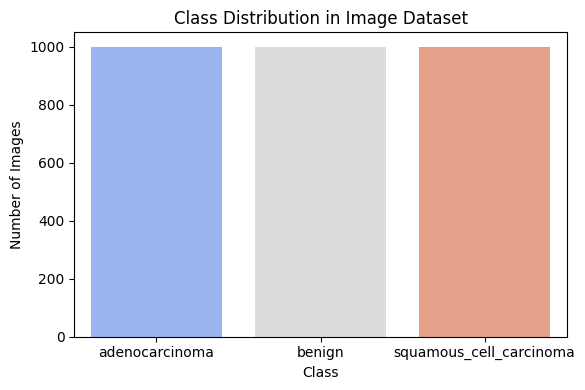

In [ ]:
# Count the number of images per class
class_counts = {}
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))
        class_counts[class_name] = num_images

plt.figure(figsize=(6, 4))
sns.barplot(x=classes, y=list(class_counts.values()), palette="coolwarm")
plt.title("Class Distribution in Image Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

### 2.5 Check Images Format

In [ ]:
# Load a random image from the dataset
label = random.choice(classes)
img_path = os.path.join(dataset_dir, label, random.choice(os.listdir(os.path.join(dataset_dir, label))))
img = Image.open(img_path)

# Get image properties
width, height = img.size
image_format = img.format

# Check color mode
mode = img.mode
if mode == 'RGB':
    color_type = 'RGB (Color)'
elif mode == 'L':
    color_type = 'Grayscale'
else:
    color_type = mode

print(f"Image size: {width} x {height} pixels")
print(f"Image format: {image_format}")
print(f"Color type: {color_type}")

Image size: 768 x 768 pixels
Image format: JPEG
Color type: RGB (Color)


### 2.6 Image Samples for Each Class

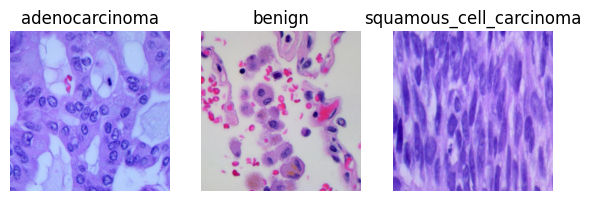

In [ ]:
plt.figure(figsize=(7, 5))
for i, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    image_name = os.listdir(class_dir)[0]
    image_path = os.path.join(class_dir, image_name)

    # Open the image
    img = Image.open(image_path)
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.show()

# 3. Data Preparation

### 3.1 Data Splitting

In [8]:
# Split dataset into training (80%), validation (10%), and testing (10%)
splitfolders.ratio('./lung_cancer_lite',
                   output='./lung_cancer_lite_split',
                   seed=1337, ratio=(.8, .1, .1),
                   group_prefix=None, move=False)

# Define directories for training, validation, and testing data
train_dir = './lung_cancer_lite_split/train'
val_dir = './lung_cancer_lite_split/val'
test_dir = './lung_cancer_lite_split/test'

Copying files: 3000 files [00:00, 4854.45 files/s]


### 3.2 Data Augmentation

In [9]:
# Function to create data generators for training, validation, and testing
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TESTING_DIR):
    # Augment and normalize training data
    train_datagen = ImageDataGenerator(rescale=1.0/255,
                                     rotation_range=15,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     shear_range=0.1,
                                     zoom_range=0.1,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

    # Create generator for training data
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(224, 224))

    # Normalize validation data without augmentation
    validation_datagen = ImageDataGenerator(rescale=1.0/255)

    # Create generator for validation data
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                    batch_size=32,
                                                                    class_mode='categorical',
                                                                    target_size=(224, 224))

    # Normalize test data without augmentation
    testing_datagen = ImageDataGenerator(rescale=1.0/255)

    # Create generator for test data
    testing_generator = testing_datagen.flow_from_directory(directory=TESTING_DIR,
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  target_size=(224, 224),
                                                  shuffle=False)

    return train_generator, validation_generator, testing_generator

# Generate training, validation, and testing data
train_generator, validation_generator, testing_generator = train_val_generators(train_dir, val_dir, test_dir)

Found 2400 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [10]:
print("Class Indices:", train_generator.class_indices)
print("Total Images in Training Set:", train_generator.samples)
print("Total Images in Validation Set:", validation_generator.samples)
print("Total Images in Test Set:", testing_generator.samples)

Class Indices: {'adenocarcinoma': 0, 'benign': 1, 'squamous_cell_carcinoma': 2}
Total Images in Training Set: 2400
Total Images in Validation Set: 300
Total Images in Test Set: 300


In [11]:
batch_images, batch_labels = next(train_generator)
print("Batch Shape:", batch_images.shape)
print("First 5 Labels:", batch_labels[:5])

Batch Shape: (32, 224, 224, 3)
First 5 Labels: [[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


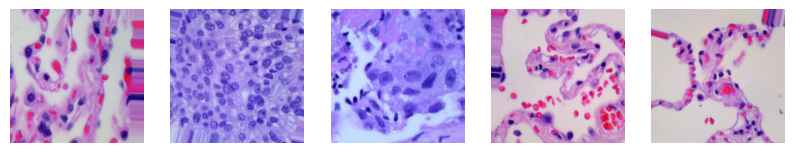

In [12]:
import matplotlib.pyplot as plt

# Get a batch
batch_images, batch_labels = next(train_generator)

# Show first 5 images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(batch_images[i])
    plt.axis('off')
plt.show()

# 4. Modeling

### 4.1 ConvNext Model

In [ ]:
from tensorflow.keras.applications import ConvNeXtBase

# Load the ConvNeXtBase model from Keras
base_model = ConvNeXtBase(input_shape=(224, 224, 3),
              include_top=False,
              weights='imagenet')

# Freeze all layers in the model
for layer in base_model.layers:
  layer.trainable = False

I0000 00:00:1746759421.862250      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746759421.863034      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### 4.2 Final Model for Transfer Learning

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs)

# Flatten layer to convert 2D output to 1D
x = layers.Flatten()(x)

# Fully connected layers with 256 and 512 neurons, using ReLU activation
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Output layer with 3 neurons and softmax activation function
outputs = layers.Dense(3, activation='softmax')(x)

final_model = Model(inputs, outputs)
final_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convnext_base (Functional)           │ (None, 7, 7, 1024)          │      87,566,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      12,845,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,544,899 (383.55 MB)

 Trainable params: 12,978,435 (49.51 MB)

 Non-trainable params: 87,566,464 (334.04 MB)

### 4.3 Compiling Final Model

In [ ]:
final_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001),
    metrics=['accuracy'])

### 4.4 Training Final Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint_callback = ModelCheckpoint(
    filepath='best_model82.keras',
    save_best_only=True,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max')

In [17]:
%%time
history = final_model.fit(
    train_generator,
    epochs=55,
    batch_size=32,
    validation_data=validation_generator,
    verbose=2,
    callbacks=[model_checkpoint_callback])

Epoch 1/55


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746759457.910441     123 service.cc:148] XLA service 0x7b7d80011dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746759457.911562     123 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746759457.911583     123 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746759460.472311     123 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1746759463.359929     123 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing war

75/75 - 87s - 1s/step - accuracy: 0.7412 - loss: 0.6340 - val_accuracy: 0.8533 - val_loss: 0.3922
Epoch 2/55
75/75 - 41s - 551ms/step - accuracy: 0.8313 - loss: 0.4085 - val_accuracy: 0.8867 - val_loss: 0.3309
Epoch 3/55
75/75 - 40s - 536ms/step - accuracy: 0.8379 - loss: 0.3737 - val_accuracy: 0.8833 - val_loss: 0.3167
Epoch 4/55
75/75 - 44s - 591ms/step - accuracy: 0.8712 - loss: 0.3174 - val_accuracy: 0.8900 - val_loss: 0.2858
Epoch 5/55
75/75 - 41s - 542ms/step - accuracy: 0.8667 - loss: 0.3141 - val_accuracy: 0.8900 - val_loss: 0.3009
Epoch 6/55
75/75 - 41s - 546ms/step - accuracy: 0.8783 - loss: 0.2837 - val_accuracy: 0.8767 - val_loss: 0.3197
Epoch 7/55
75/75 - 44s - 583ms/step - accuracy: 0.8863 - loss: 0.2724 - val_accuracy: 0.9000 - val_loss: 0.2543
Epoch 8/55
75/75 - 41s - 542ms/step - accuracy: 0.8996 - loss: 0.2603 - val_accuracy: 0.8800 - val_loss: 0.2730
Epoch 9/55
75/75 - 41s - 541ms/step - accuracy: 0.8854 - loss: 0.2691 - val_accuracy: 0.8900 - val_loss: 0.2538
Epoch 

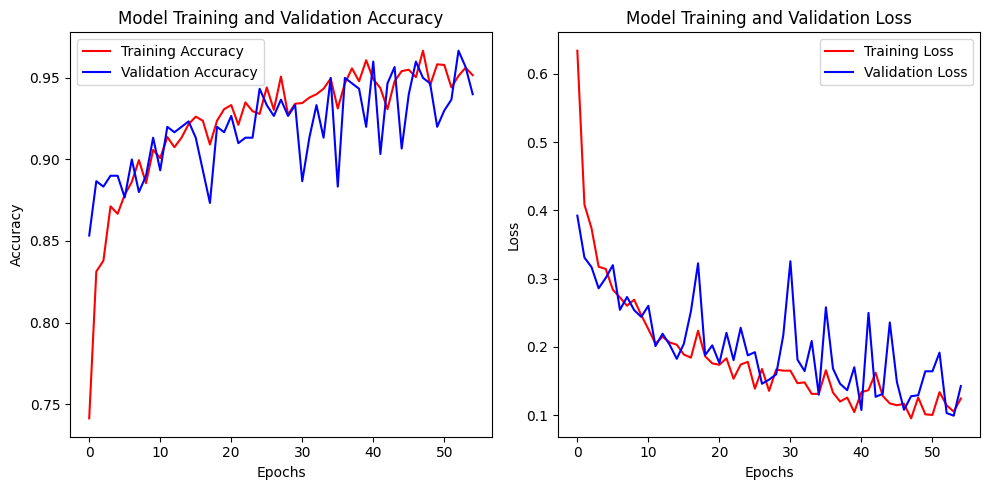

In [18]:
# Retrieve accuracy and loss values from training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Create two subplots (1 row, 2 columns) for training history visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot training and validation accuracy
ax1.plot(epochs, acc, 'r', label='Training Accuracy')
ax1.plot(epochs, val_acc, 'b', label='Validation Accuracy')
ax1.set_title('Model Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot training and validation loss
ax2.plot(epochs, loss, 'r', label='Training Loss')
ax2.plot(epochs, val_loss, 'b', label='Validation Loss')
ax2.set_title('Model Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust plot layout
plt.tight_layout()

# Save plots
plt.savefig('train_acc_loss_plot.png')
# Show plots
plt.show()

In [ ]:
from IPython.display import FileLink
FileLink('best_model82.keras')

# 5. Evaluation

### 5.1 Evaluating Final Model with Test Set

In [20]:
model_saved = tf.keras.models.load_model('./best_model82.keras')

In [ ]:
# Evaluate the model using the test set
print('Evaluating model accuracy on test data')
results = model_saved.evaluate(testing_generator, batch_size=32)
print('Test loss, test accuracy:', results)

Evaluate model accuracy on test data
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 641ms/step - accuracy: 0.9294 - loss: 0.1719
test loss, test acc: [0.17049743235111237, 0.9366666674613953]


### 5.2 Confusion Matrix

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 446ms/step


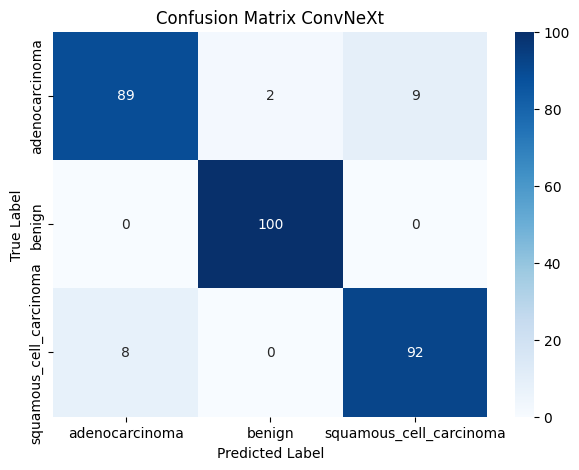

In [ ]:
# Predicting test data
predictions = model_saved.predict(testing_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels from the test data
true_classes = testing_generator.classes
class_labels = list(testing_generator.class_indices.keys())

# Create the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix ConvNeXt')
plt.savefig('conf_matrix.png')
plt.show()

### 5.3 Classification Report

In [ ]:
# Classification report
class_report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print("Classification Report:")
print(class_report)

Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.92      0.89      0.90       100
                 benign       0.98      1.00      0.99       100
squamous_cell_carcinoma       0.91      0.92      0.92       100

               accuracy                           0.94       300
              macro avg       0.94      0.94      0.94       300
           weighted avg       0.94      0.94      0.94       300



In [ ]:
class_report2 = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)

with open("class_report_test.json", "w") as f:
    json.dump({"classification_report": class_report2}, f)

### 5.4 Predicting Test Data

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 452ms/step


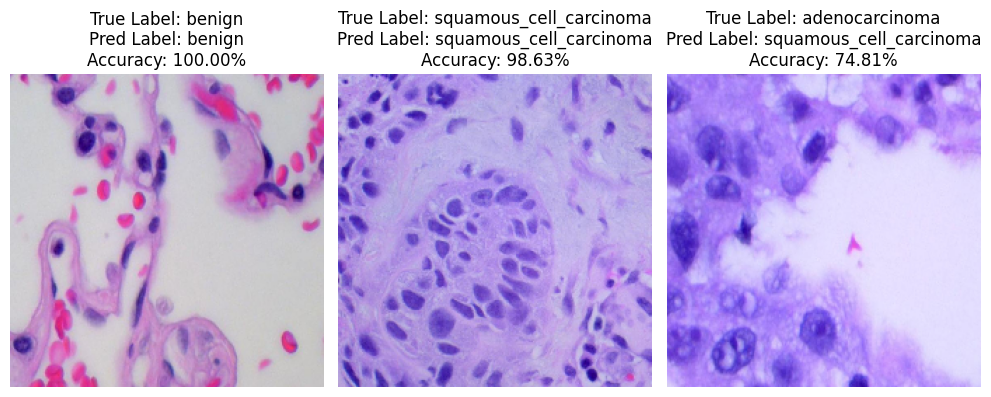

In [ ]:
testing_generator.reset()

# Retrieve all images and labels from the generator
all_test_images = []
all_test_labels = []

for i in range(len(testing_generator)):
    batch_images, batch_labels = testing_generator[i]
    all_test_images.extend(batch_images)
    all_test_labels.extend(batch_labels)

# Convert to NumPy arrays
all_test_images = np.array(all_test_images)
all_test_labels = np.array(all_test_labels)

# Randomly select 3 indices from the entire test data
random_indices = np.random.choice(len(all_test_images), size=3, replace=False)

# Predict all test data (to save time)
predictions = model_saved.predict(all_test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(all_test_labels, axis=1)

# Visualize 3 random test images with predictions
plt.figure(figsize=(10, 7))
for i, index in enumerate(random_indices):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(all_test_images[index])

    true_label = class_labels[true_classes[index]]
    predicted_label = class_labels[predicted_classes[index]]
    accuracy = np.max(predictions[index]) * 100

    plt.title(f'True Label: {true_label}\nPred Label: {predicted_label}\nConfidence: {accuracy:.2f}%')
    plt.axis('off')

plt.tight_layout()
plt.savefig('test_predict.png')
plt.show()